In [1]:
import sys
sys.path.append("../Python")
from array import array
import time
import numpy as np
import feather
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import os
import ROOT as R

Welcome to JupyROOT 6.29/01


# ML Tests
We load the *Pandas* version of a dataset from disk. Note that this is a bit of a shift in how a dataframe behaves!
By rounding the "true_e" parameter we undo the tiny variation introduced by writing and reading the data.

In [2]:
df = pd.read_feather("electrons_fiducial_cut_n1.feather")
df['true_e_rounded'] = df['true_e'].round(1)               # Rounded version to one decimal.
ran_loc = np.random.permutation(len(df))                   # To randomize the entries in the data set.
print(f"Number of events in data set is {len(df)}")
df.iloc[ran_loc].head()

Number of events in data set is 721897


,energy,energy_cor,x,y,x_cor,y_cor,nhits,seed_e,seed_ix,seed_iy,true_e,score_e,score_x,score_y,true_e_rounded
51974,3.762953,4.327567,-203.024597,56.766766,-210.597885,56.611301,8,2.235403,-18,3,4.105632,4.083338,-207.516979,57.313430,4.1
190644,1.502236,1.665201,-75.711632,58.387905,-77.002739,58.265472,5,1.130379,-9,3,1.837586,1.817061,-76.846670,57.235283,1.8
188097,2.313992,2.596205,-58.985336,61.982269,-61.278469,61.986359,6,1.458941,-8,3,2.614681,2.577097,-60.555757,62.060509,2.6
616027,3.386587,3.871040,89.848274,66.140388,90.711952,66.275909,11,2.132554,4,4,3.674482,3.638129,92.260003,65.336940,3.7
60843,4.037986,4.689852,189.683929,42.986755,193.055405,42.407944,13,2.545778,11,2,4.338901,4.310226,192.365918,42.996258,4.3


## Plots
We can plot the variables against each other, but I don't think we learn a whole lot from this. Since we can only
plot a bit of the data this way, we do a random sample, which we stick in p_df.

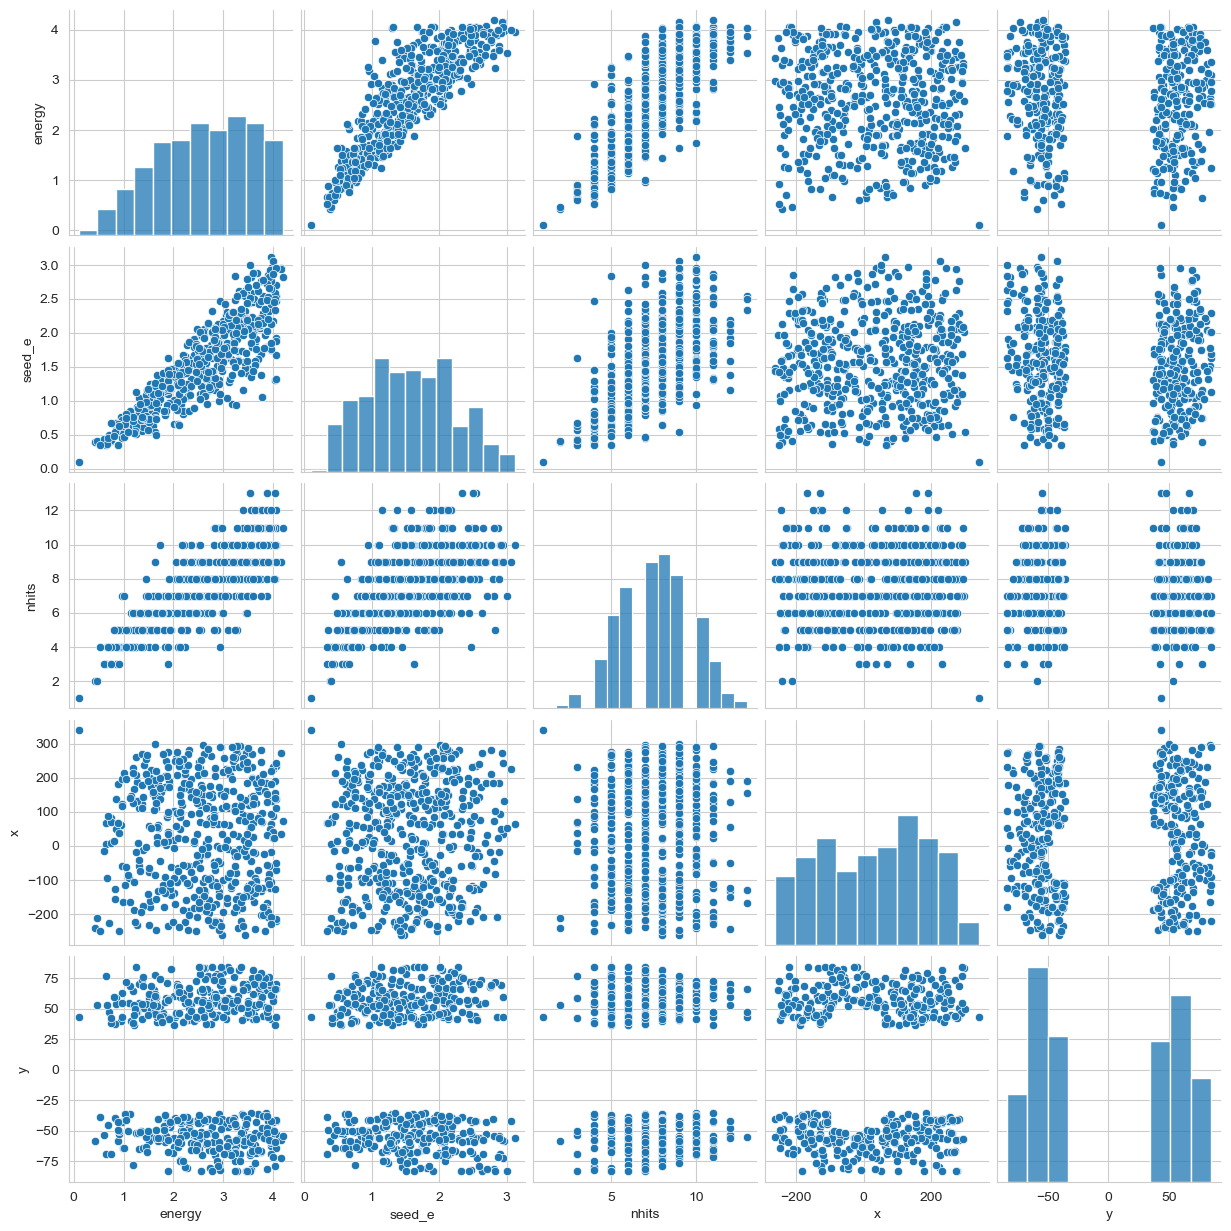

In [ ]:
# Partial dataset
p_df = df.iloc[ran_loc[0:500]]
#df.iloc[locs][["energy","true_e","score_e","x","y"]]
sns.pairplot(p_df[["energy","seed_e","nhits","x","y"]])  # Grab some and plot against each other

In [ ]:
g = sns.PairGrid(p_df, vars=['energy', 'seed_e','nhits', 'x', 'y'], hue='true_e_rounded', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8, s=1.5)
g.add_legend();
g.savefig("Variable_relations_ecal_cluster.pdf")

# Try Pricipal Component Analysis
First we need to drop the prediction columns, (the Y) "true_e", "score_e", "score_x" and "score_y" from df.
We can also extend the data with the variables that were used by Andrea for his fits:
$$ f(E) = \frac{A}{E} + \frac{B}{\sqrt{E}} + C $$

In [ ]:
df['one_over_e'] = 1/df['energy']
df['one_over_sqrt_e'] = 1/np.sqrt(df['energy'])
dfc = df.copy()
dfc = dfc.drop(columns=["true_e","true_e_rounded","score_e","score_x","score_y","seed_ix", "seed_iy","energy_cor","x_cor","y_cor"])

In [ ]:
dfc.head()

In [ ]:
pca = PCA()
XD = pca.fit_transform(dfc)
print("Transposed components. This way the *columns* read like the eigen vectors.")
pca.components_.T

In [ ]:
pca.explained_variance_ratio_.reshape(1,7)

### PCA Results
The PCA results state that two combinations of the input data explain 99% of variance in the data. Since these components are basically $x$ and $y$, it
is not clear if this is going to help us with our fits.

Quick test to make sure we understand what the output actually gives us:

In [ ]:
row = 100
for i in range(len(XD[row])):
    print(f"{XD[row,i]:9.4f}, {np.dot((dfc.iloc[row,:] - pca.mean_),(pca.components_[i,:])):9.4f}, {pca.transform(dfc.iloc[row:row+1,:])[0,i]:9.4f}")

In [ ]:
XDdat = pd.DataFrame(XD, columns=[str(x) for x in range(len(XD[0]))])
XDdat['true_e'] = df['true_e']
df['diff_e'] = df['true_e'] - df['energy']
XDdat['diff_e'] = df['diff_e']


In [ ]:
sns.scatterplot(XDdat.loc[ran_loc[0:2000]],x="4", y="diff_e", size = 1, hue='true_e', palette='RdBu_r')

In [ ]:
sns.scatterplot(df.loc[ran_loc[0:2000]],x="energy", y="diff_e", size = 1, hue='true_e', palette='RdBu_r')

In [ ]:
g = sns.PairGrid(df.loc[ran_loc[0:2000]], x_vars=['seed_e','x','y','nhits','one_over_e','one_over_sqrt_e'],y_vars=['diff_e'],hue='true_e_rounded', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8, s=1.5)

# Linear Regressions
We will try running the linear regressions from SkLearn over the data.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [46]:
dfc = df[["energy", "x", "y",  "nhits", "seed_e", "one_over_e", "one_over_sqrt_e"]].copy()
dfy = df[['score_e']].copy()
linreg = LinearRegression()
#
# We need to split the data set into a "fit" set and a "validate" set.
# This needs to be done on the randomized locations in iloc.
split_frac = 0.5
split_point = int(len(ran_loc)*split_frac)
fit_loc = ran_loc[0:split_point]
val_loc = ran_loc[split_point:]
dfc_fit = dfc.iloc[fit_loc]
dfy_fit = dfy.iloc[fit_loc]
dfc_val = dfc.iloc[val_loc]
dfy_val = dfy.iloc[val_loc]
%time linreg.fit(dfc_fit,dfy_fit)
Ypred_fit = linreg.predict(dfc_fit)
Ypred_val = linreg.predict(dfc_val)
print(f"Mean square error fit         = {mean_squared_error(dfy_fit,Ypred_fit)}")
print(f"Mean square error validation  = {mean_squared_error(dfy_val,Ypred_val)}")
print("Coefficients:")
for i in range(len(linreg.coef_[0])):
    print(f"[{i:2d}] {linreg.feature_names_in_[i]:16s} * {linreg.coef_[0][i]:9.5f}")
print(f"         {' ':16s} {linreg.intercept_[0]}")


CPU times: user 39 ms, sys: 11.6 ms, total: 50.6 ms
Wall time: 47 ms
Mean square error fit         = 0.028770407915061316
Mean square error validation  = 0.02914177653177415
Coefficients:
[ 0] energy           *   1.10975
[ 1] nhits            *  -0.04799
[ 2] x                *  -0.00009
[ 3] y                *  -0.00002
[ 4] seed_e           *  -0.04757
[ 5] one_over_e       *   0.27965
[ 6] one_over_sqrt_e  *  -0.89840
                          0.9931549462244929


In [47]:
print("lin_coeffs=np.array([", end="")
for i in range(len(linreg.coef_[0])):
    print(f"{linreg.coef_[0][i]},", end="")
print("])")
print(f"lin_const={linreg.intercept_[0]}")

lin_coeffs=np.array([1.1097496674734124,-0.04798735318207794,-9.130576310763213e-05,-2.1287568071510233e-05,-0.04756562529871979,0.2796549133805827,-0.8984004975697086,])
lin_const=0.9931549462244929


In [53]:
# Previous fit from the discreet data set:
disc_lin_coeffs=np.array([1.0654241015592467,-0.041129075826791095, 0, 0, -0.05135978227167387,0.3478903440606219,-1.1392337125449232])
disc_lin_const=1.175640246070988
lin_coeffs=np.array([1.1134761366532089,-0.04834579637818216,-0.0478181486467315,0.26886478500054817,-0.8593731046568551,])
lin_const=0.9631334956635773
lin_coeffs=np.array([1.1097496674734124,-0.04798735318207794,-9.130576310763213e-05,-2.1287568071510233e-05,-0.04756562529871979,0.2796549133805827,-0.8984004975697086,])
lin_const=0.9931549462244929
Ypred_old = dfc_val.dot(disc_lin_coeffs) + disc_lin_const

In [54]:
# tmp_data = {key: df.iloc[fit_loc][key].values for key in ['true_e', 'energy','energy_cor']}
# tmp_data['energy_fit'] = Ypred_fit[:,0]
# rdf_fit = R.RDF.FromNumpy(tmp_data)
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_fit'] = Ypred_val[:,0]
tmp_data['energy_fit_old'] = np.array(Ypred_old.array)
rdf_val = R.RDF.FromNumpy(tmp_data)

In [55]:
h2_true = rdf_val.Histo1D(("h_true","True Energy;E [GeV]", 1000, 0., 4.),"true_e")
h2_clus = rdf_val.Histo1D(("h_clus","Cluster Energy;E [GeV]", 1000, 0., 4.),"energy")
h2_clus_cor = rdf_val.Histo1D(("h_clus_cor","Cluster Energy Cor;E [GeV]", 1000, 0., 4.),"energy_cor")
h2_fit = rdf_val.Histo1D(("h_fit","Fit Energy;E [GeV]", 1000, 0., 4.),"energy_fit")
h2_fit_old = rdf_val.Histo1D(("h_fit_old","Old Fit Energy;E [GeV]", 1000, 0., 4.),"energy_fit_old")
h2_df_clus = rdf_val.Define("d","true_e - energy").Histo1D(("h_df_clus","Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h2_df_clus_cor = rdf_val.Define("d","true_e - energy_cor").Histo1D(("h_df_clus_cor","Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2,0.8),"d")
h2_df_fit = rdf_val.Define("d","true_e - energy_fit").Histo1D(("h_df_fit","Diff True - Fit E;#Delta E [GeV]", 1000, -0.5,0.8),"d")
h2_df_fit_old = rdf_val.Define("d","true_e - energy_fit_old").Histo1D(("h_df_fit_old","Diff True - Old Fit E;#Delta E [GeV]", 1000, -0.5,0.8),"d")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Info in <TCanvas::Print>: pdf file Electron_score_e_LR1.pdf has been created


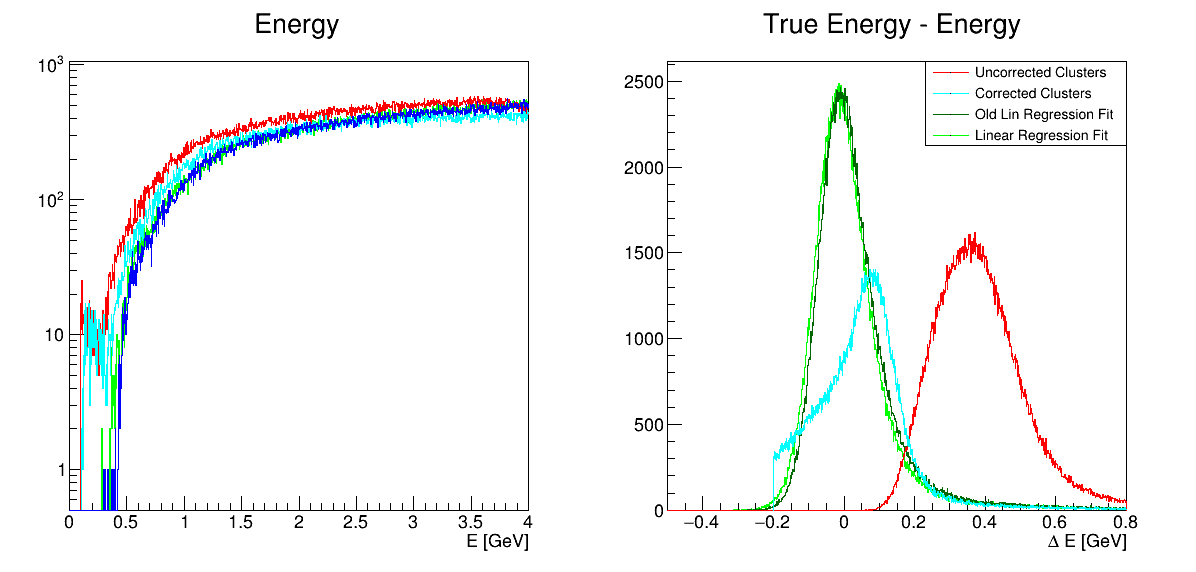

In [56]:
cc = R.TCanvas("cc","CC",1200,600)
cc.Divide(2,1)
p1 = cc.cd(1)
p1.SetLogy()
h2_clus.SetLineColor(R.kRed)
h2_clus_cor.SetLineColor(R.kCyan)
h2_fit.SetLineColor(R.kGreen)
h2_fit.SetStats(0)
h2_fit.SetTitle("Energy")
h2_fit.Draw()
h2_clus.Draw("same")
h2_clus_cor.Draw("same")
h2_true.SetLineColor(R.kBlue)
h2_true.Draw("same")
p2 = cc.cd(2)
h2_df_clus.SetLineColor(R.kRed)
h2_df_clus_cor.SetLineColor(R.kCyan)
h2_df_fit.SetLineColor(R.kGreen)
h2_df_fit.SetStats(0)
h2_df_fit.SetTitle("True Energy - Energy")
h2_df_fit.Draw()
h2_df_fit_old.SetLineColor(R.kGreen+3)
h2_df_fit_old.Draw("same")
h2_df_clus.Draw("same")
h2_df_clus_cor.Draw("same")
leg0_p2 = R.TLegend(0.55,0.75,0.9,0.9)
leg0_p2.AddEntry(h2_df_clus.GetPtr(),"Uncorrected Clusters")
leg0_p2.AddEntry(h2_df_clus_cor.GetPtr(),"Corrected Clusters")
leg0_p2.AddEntry(h2_df_fit_old.GetPtr(),"Old Lin Regression Fit")
leg0_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg0_p2.Draw()
cc.Draw()
cc.SaveAs("Electron_score_e_LR1.pdf")

In [45]:
# Number of entries in each histogram.
print(h2_df_clus.GetEntries(), h2_df_clus_cor.GetEntries(), h2_df_fit.GetEntries())

360949.0 360949.0 360949.0


## Going to higher order polynomial fit.
We can go to cubic polynomial combinations of the variables, and trying to be careful to weed out obvious trouble parameters. This does not seem to buy us any improvement in the fit. It appears that higher order terms do not help.

In [80]:
pol_feature = PolynomialFeatures(degree=5, include_bias=False)
dfc_fit_drop = dfc_fit.drop(columns=["one_over_e","one_over_sqrt_e"])
tmp = pol_feature.fit_transform(dfc_fit_drop)
dfc_fit_pol = pd.DataFrame(tmp, columns=pol_feature.get_feature_names_out())
dfc_fit_pol['one_over_e'] = 1/dfc_fit_pol['energy']
dfc_fit_pol['one_over_sqrt_e'] = 1/np.sqrt(dfc_fit_pol['energy'])
dfc_val_drop = dfc_val.drop(columns=["one_over_e","one_over_sqrt_e"])
tmp = pol_feature.fit_transform(dfc_val_drop)
dfc_val_pol = pd.DataFrame(tmp, columns=pol_feature.get_feature_names_out())
dfc_val_pol['one_over_e'] = 1/dfc_val_pol['energy']
dfc_val_pol['one_over_sqrt_e'] = 1/np.sqrt(dfc_val_pol['energy'])

linreg_pol = LinearRegression()
%time linreg_pol.fit(dfc_fit_pol,dfy_fit)
Ypred_fit_pol = linreg_pol.predict(dfc_fit_pol)
Ypred_val_pol = linreg_pol.predict(dfc_val_pol)
print(f"Mean square error for fit        = {mean_squared_error(dfy_fit,Ypred_fit)}")
print(f"Mean square error for validation = {mean_squared_error(dfy_val,Ypred_val)}")
for i in range(len(linreg_pol.coef_[0])):
    print(f"[{i:2d}] {linreg_pol.feature_names_in_[i]:16s} * {linreg_pol.coef_[0][i]:9.5f}")
print(f"         {' ':16s} {linreg_pol.intercept_[0]}")

CPU times: user 16.9 s, sys: 865 ms, total: 17.8 s
Wall time: 4.37 s
Mean square error for fit        = 0.028770407915061316
Mean square error for validation = 0.02914177653177415
[ 0] energy           *   1.46073
[ 1] nhits            *  -0.25250
[ 2] x                *   0.00142
[ 3] y                *  -0.00000
[ 4] seed_e           *  -1.93661
[ 5] energy^2         *   1.68579
[ 6] energy nhits     *  -0.62219
[ 7] energy x         *  -0.00150
[ 8] energy y         *  -0.00091
[ 9] energy seed_e    *  -1.08433
[10] nhits^2          *   0.11615
[11] nhits x          *  -0.00027
[12] nhits y          *   0.00004
[13] nhits seed_e     *   0.46613
[14] x^2              *  -0.00000
[15] x y              *  -0.00000
[16] x seed_e         *  -0.00058
[17] y^2              *  -0.00002
[18] y seed_e         *   0.00020
[19] seed_e^2         *   1.88498
[20] energy^3         *  -0.44940
[21] energy^2 nhits   *  -0.31329
[22] energy^2 x       *   0.00052
[23] energy^2 y       *  -0.00151
[24]

In [81]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_pol_fit'] = Ypred_val_pol[:,0]
rdf_pol = R.RDF.FromNumpy(tmp_data)

In [82]:
h3_fit = rdf_pol.Histo1D(("h3_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_pol_fit")
h3_df_fit = rdf_pol.Define("d", "true_e - energy_pol_fit").Histo1D(
    ("h3_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc
Info in <TCanvas::Print>: pdf file Electron_score_e_LR3.pdf has been created


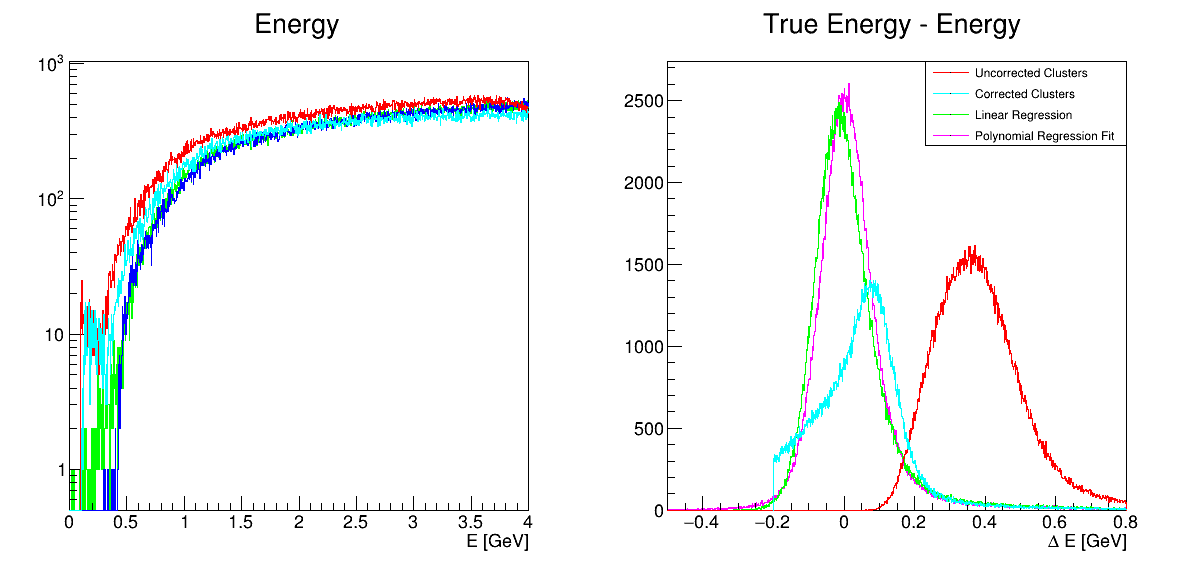

In [83]:
cc = R.TCanvas("cc","CC",1200,600)
cc.Divide(2,1)
p1 = cc.cd(1)
p1.SetLogy()
#h_true.SetLineColor(R.kBlue)
#h_true.Draw()
h2_clus.SetLineColor(R.kRed)
h2_clus_cor.SetLineColor(R.kCyan)
h3_fit.SetLineColor(R.kGreen)
h3_fit.SetStats(0)
h3_fit.SetTitle("Energy")
h3_fit.Draw()
h2_true.Draw("same")
h2_clus.Draw("same")
h2_clus_cor.Draw("same")
p2 = cc.cd(2)
h2_df_clus.SetLineColor(R.kRed)
h2_df_clus_cor.SetLineColor(R.kCyan)
h3_df_fit.SetLineColor(R.kMagenta)
h3_df_fit.SetStats(0)
h3_df_fit.SetTitle("True Energy - Energy")
h3_df_fit.Draw()
h2_df_fit.SetLineColor(R.kGreen)
h3_df_fit.Draw()
h2_df_fit.SetLineWidth(1)
h2_df_fit.Draw("same")
h2_df_clus.Draw("same")
h2_df_clus_cor.Draw("same")
leg0_p2 = R.TLegend(0.55,0.75,0.9,0.9)
leg0_p2.AddEntry(h2_df_clus.GetPtr(),"Uncorrected Clusters")
leg0_p2.AddEntry(h2_df_clus_cor.GetPtr(),"Corrected Clusters")
leg0_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression")
leg0_p2.AddEntry(h3_df_fit.GetPtr(),"Polynomial Regression Fit")
leg0_p2.Draw()
cc.Draw()
cc.SaveAs("Electron_score_e_LR3.pdf")

In [85]:
print(f"Corrected clusters Mean = {h2_df_clus_cor.GetValue().GetMean():8.6f}  Stdev = {h2_df_clus_cor.GetValue().GetStdDev():8.6f}")
print(f"Linear Fit         Mean = {h2_df_fit.GetValue().GetMean():8.6f}  Stdev = {h2_df_fit.GetValue().GetStdDev():8.6f}")
print(f"Polinomial Fit     Mean = {h3_df_fit.GetValue().GetMean():8.6f}  Stdev = {h3_df_fit.GetValue().GetStdDev():8.6f}")

Corrected clusters Mean = 0.048901  Stdev = 0.130139
Linear Fit         Mean = 0.017018  Stdev = 0.116173
Polinomial Fit     Mean = 0.020215  Stdev = 0.110136


# Going to a Neural Network - ML1 - Linear
So then the next level up would be to construct something that behaves more like a neural network. In the first step we exercise the
system to do a linear fit equivalent to the linear regression, but this time with a "neural network".

In [86]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.9.0


In [91]:
model = keras.Sequential([
    layers.Dense(units=1,activation="linear", input_shape=(7,),
                 kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.1,stddev=0.01),
                 bias_initializer=tf.keras.initializers.Zeros())
])
model.compile(
    # optimizer=tf.optimizers.SGD(learning_rate=0.000001),
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss="mse" # tf.keras.losses.MeanSquaredError() # alternate: 'mean_absolute_error'='mae', 'mean_squared_error' = 'mse'
)

In [92]:
weights_store = [[np.array([[1.0756719],[-0.04075409],[0],[0],[-0.05301237],[0.29785597],[-1.011633]]), np.array([1.088990569114685])]]
model.set_weights(weights_store[-1])
#weights = model.get_weights()
#print(weights)

In [93]:
model.get_weights()

[array([[ 1.0756719 ],
        [-0.04075409],
        [ 0.        ],
        [ 0.        ],
        [-0.05301237],
        [ 0.29785597],
        [-1.011633  ]], dtype=float32),
 array([1.0889906], dtype=float32)]

In [94]:
history = model.fit(dfc_fit, dfy_fit,  verbose=1, epochs=1)

11280/11280 [==============================] - 44s 4ms/step - loss: 0.0291


2023-04-14 17:59:44.500606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [95]:
# Ypred_val_NN1 =  model.predict(dfc_val)  ## !! This is *very* slow evaluating, so we use a much faster equivalent method.
weights = model.get_weights()
Ypred_fit_NN1 = np.dot(dfc_fit, weights[0]) + weights[1][0]
Ypred_val_NN1 = np.dot(dfc_val, weights[0]) + weights[1][0]
print(f"Final value for the loss         = {history.history['loss'][-1]}")
print(f"Mean square error for the fit    = {mean_squared_error(Ypred_fit_NN1, dfy_fit)}")
print(f"Mean square error for validation = {mean_squared_error(Ypred_val_NN1, dfy_val)}")
print("Weights = ")
print("[np.array([", end="")
for i in range(len(weights[0])):
    print(f"[{weights[0][i]}],", end="")
print(f"]), np.array([{weights[1][0]}])]")
weights_store.append(weights)

Final value for the loss         = 0.029146846383810043
Mean square error for the fit    = 0.029105560538181918
Mean square error for validation = 0.02948308084922081
Weights = 
[np.array([[[1.0965121]],[[-0.04699599]],[[-6.17024e-05]],[[0.00021953]],[[-0.04421167]],[[0.30551994]],[[-1.010666]],]), np.array([1.0862575769424438])]


In [96]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'energy','energy_cor']}
tmp_data['energy_NN1'] = Ypred_val_NN1[:,0]
rdf_NN1 = R.RDF.FromNumpy(tmp_data)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc4
Info in <TCanvas::Print>: pdf file Electron_score_e_NN1.pdf has been created


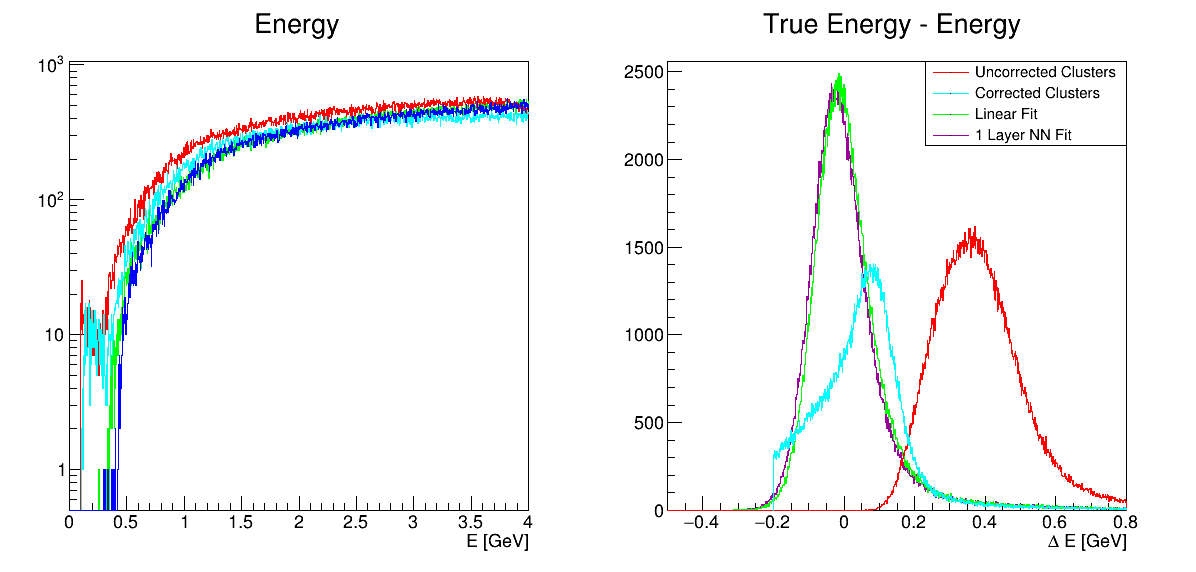

In [100]:
h4_true = rdf_NN1.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h4_clus = rdf_NN1.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h4_clus_cor = rdf_NN1.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h4_fit = rdf_NN1.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN1")
h4_df_clus = rdf_NN1.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h4_df_clus_cor = rdf_NN1.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h4_df_fit = rdf_NN1.Define("d", "true_e - energy_NN1").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc4 = R.TCanvas("cc4", "CC4", 1200, 600)
cc4.Divide(2, 1)
p1 = cc4.cd(1)
p1.SetLogy()
h4_clus.SetLineColor(R.kRed)
h4_clus_cor.SetLineColor(R.kCyan)
h4_fit.SetLineColor(R.kGreen)
h4_fit.SetStats(0)
h4_fit.SetTitle("Energy")
h4_fit.Draw()
h4_clus.Draw("same")
h4_clus_cor.Draw("same")
h4_true.SetLineColor(R.kBlue)
h4_true.Draw("same")
p2 = cc4.cd(2)
h4_df_clus.SetLineColor(R.kRed)
h4_df_clus_cor.SetLineColor(R.kCyan)
h4_df_fit.SetLineColor(R.kMagenta+2)
h4_df_fit.SetStats(0)
h4_df_fit.SetTitle("True Energy - Energy")
h4_df_fit.Draw()
h2_df_fit.Draw("same")
h4_df_clus.Draw("same")
h4_df_clus_cor.Draw("same")
leg4_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg4_p2.AddEntry(h4_df_clus.GetPtr(), "Uncorrected Clusters")
leg4_p2.AddEntry(h4_df_clus_cor.GetPtr(), "Corrected Clusters")
leg4_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Fit")
leg4_p2.AddEntry(h4_df_fit.GetPtr(), "1 Layer NN Fit")
leg4_p2.Draw()
cc4.Draw()
cc4.SaveAs("Electron_score_e_NN1.pdf")

# Semi-Deep Neural Network, 2 Layer.
Working with more parameters and some non-linear part, we end up with a lot more parameters, much less of an idea what these parameters do,
and the results are no better, with a Mean Squared Error of 0.022. Just the training takes a lot longer.

Training for this model is in a separate Python file, MLTrainer2.py
Here we copy the weights from that training.

In [114]:
model2 = keras.Sequential([
    keras.Input(shape=(7,)),
    layers.Dense(20, activation="linear",
                 kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.01),
                 bias_initializer=tf.keras.initializers.Zeros()),
    layers.Dense(1, activation="elu",
                 kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.1, stddev=0.01),
                 bias_initializer=tf.keras.initializers.Zeros(),
                 kernel_regularizer=keras.regularizers.l2(0))
])

model2.compile(
    # optimizer=tf.optimizers.SGD(learning_rate=0.000001),
    optimizer=tf.optimizers.Adam(learning_rate=0.0001),
    loss="mse"
    # tf.keras.losses.MeanSquaredError() # alternate: 'mean_absolute_error'='mae', 'mean_squared_error' = 'mse'
)


In [115]:
import json
with open("electrons_fiducial_cut_n1_M2.json", "r") as read_file:
    decodedArray = json.load(read_file)
weight_array = decodedArray['weights_store']
weights = []
for w in weight_array[-1]:
    weights.append(np.array(w))
model2.set_weights(weights)

In [116]:
# Note that even just running the prediction now takes quite a bit of time!
%time Ypred_fit_NN2 = model2.predict(dfc_fit)

11280/11280 [==============================] - 25s 2ms/step
CPU times: user 14.5 s, sys: 8.7 s, total: 23.2 s
Wall time: 26.4 s


2023-04-14 18:15:47.831973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [117]:
%time Ypred_val_NN2 = model2.predict(dfc_val)

11280/11280 [==============================] - 26s 2ms/step
CPU times: user 16.3 s, sys: 10.1 s, total: 26.4 s
Wall time: 27.4 s


In [118]:
print(f"MSE Fit: {mean_squared_error(Ypred_fit_NN2, dfy_fit)}")
print(f"MSE Val: {mean_squared_error(Ypred_val_NN2, dfy_val)}")

MSE Fit: 6.995276027233719
MSE Val: 6.994706512038405


In [111]:
tmp_data = {key: df.iloc[val_loc][key].values for key in ['true_e', 'score_e', 'energy','energy_cor']}
tmp_data['energy_NN2'] = Ypred_val_NN2[:,0]
rdf_NN2 = R.RDF.FromNumpy(tmp_data)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc5
Info in <TCanvas::Print>: pdf file Electron_score_e_NN2.pdf has been created


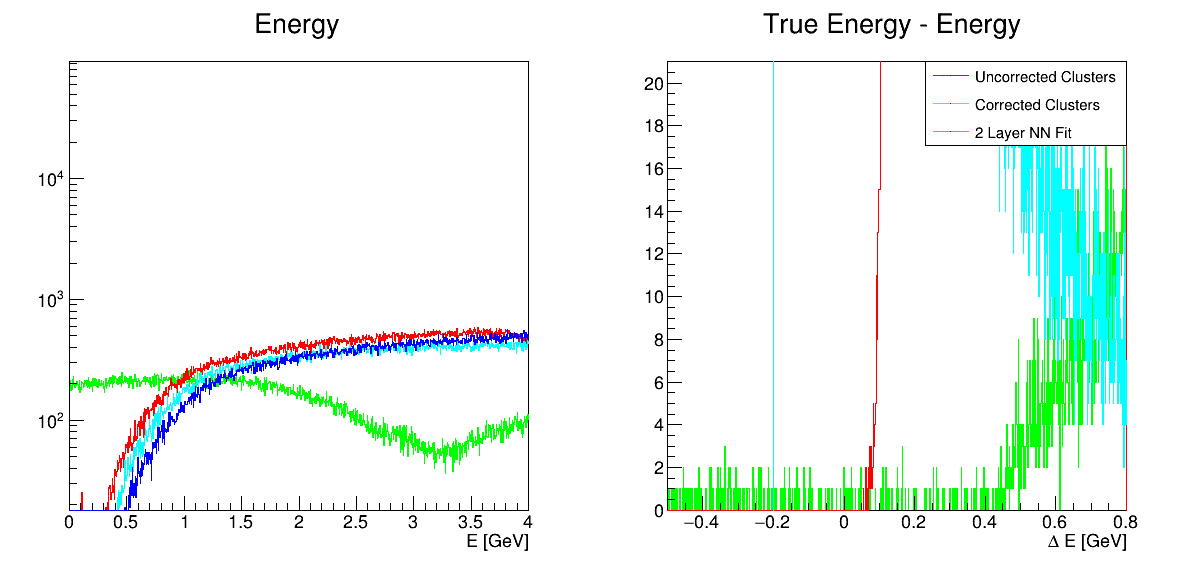

In [112]:
h5_true = rdf_NN2.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h5_clus = rdf_NN2.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h5_clus_cor = rdf_NN2.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h5_fit = rdf_NN2.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN2")
h5_df_clus = rdf_NN2.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h5_df_clus_cor = rdf_NN2.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h5_df_fit = rdf_NN2.Define("d", "true_e - energy_NN2").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc5 = R.TCanvas("cc5", "cc5", 1200, 600)
cc5.Divide(2, 1)
p1 = cc5.cd(1)
p1.SetLogy()
h5_clus.SetLineColor(R.kRed)
h5_clus_cor.SetLineColor(R.kCyan)
h5_fit.SetLineColor(R.kGreen)
h5_fit.SetStats(0)
h5_fit.SetTitle("Energy")
h5_fit.Draw()
h5_clus.Draw("same")
h5_clus_cor.Draw("same")
h5_true.SetLineColor(R.kBlue)
h5_true.Draw("same")
p2 = cc5.cd(2)
h5_df_clus.SetLineColor(R.kRed)
h5_df_clus_cor.SetLineColor(R.kCyan)
h5_df_fit.SetLineColor(R.kGreen)
h5_df_fit.SetStats(0)
h5_df_fit.SetTitle("True Energy - Energy")
h5_df_fit.Draw()
h5_df_clus.Draw("same")
h5_df_clus_cor.Draw("same")
leg5_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg5_p2.AddEntry(h5_df_clus.GetPtr(), "Uncorrected Clusters")
leg5_p2.AddEntry(h5_df_clus_cor.GetPtr(), "Corrected Clusters")
leg5_p2.AddEntry(h5_df_fit.GetPtr(), "2 Layer NN Fit")
leg5_p2.Draw()
cc5.Draw()
cc5.SaveAs("Electron_score_e_NN2.pdf")

In [44]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 20)                120       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


# Deep Learning Model
So finally, we try a deep learning model, with 10801 parameters, so you have absolutely no clue what is happening inside.
To limit the training time, we train the model on 5% of the data, and validate with 10% of the data.

This model appears to be just marginally better, with a loss (MSE) of 0.0174 instead of 0.022. This was reached after 40 batch steps, or 8 epochs.
Training a full 20 epocs only sees the loss bounce between 0.0206 and 0.0173.

The model requires 8 GB to train, and about 7 seconds per batch (31s to train of 50% of the data).

```./MLTrainer3.py --rate 0.01  --rate 0.001 -t 5 -s 5 -n 20  --root -d  electrons_fiducial_cut_n1.feather
Tensorflow version: 2.11.0
Starting values:
Mean square error for the fit    = 0
Mean square error for validation = 0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #
=================================================================
 dense (Dense)               (None, 100)               600

 dense_1 (Dense)             (None, 100)               10100

 dense_2 (Dense)             (None, 1)                 101

=================================================================
Total params: 10,801
Trainable params: 10,801
Non-trainable params: 0
...
...
Final values:
Loss                             = 0.018097009509801865
Mean square error for the fit    = 0.017716576601145624
Mean square error for validation = 0.017451943974658508
```

This model had no "regularization" of the parameters, and while the validation and fit loss are very close, the graph of the result makes it seem
that there is some level of over-fitting, or at least strange behavior, happening here.

In [55]:
rfile = R.TFile("MLTrainer3_data_val_no_regulation.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()

vector<string>{ "energy", "energy_NN", "energy_cor", "nhits", "one_over_e", "one_over_sqrt_e", "score_e", "seed_e", "true_e" }

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_no_regulation.pdf has been created


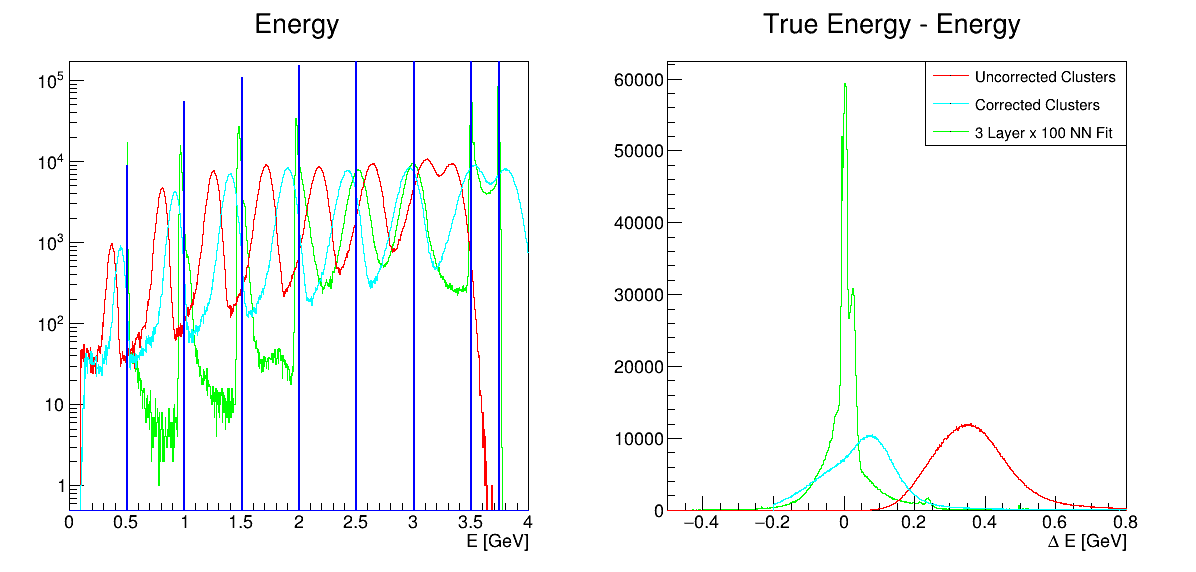

In [56]:
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_no_regulation.pdf")

## Add Regulation to the Model
We add an L2 regulation to all the layers in the model. The result is now again close to the previous results:
```
Loss                             = 0.05406823009252548
Mean square error for the fit    = 0.02278002218551103
Mean square error for validation = 0.022799865437876887
```
And the histogram looks the same again too.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_L2_pt01.pdf has been created


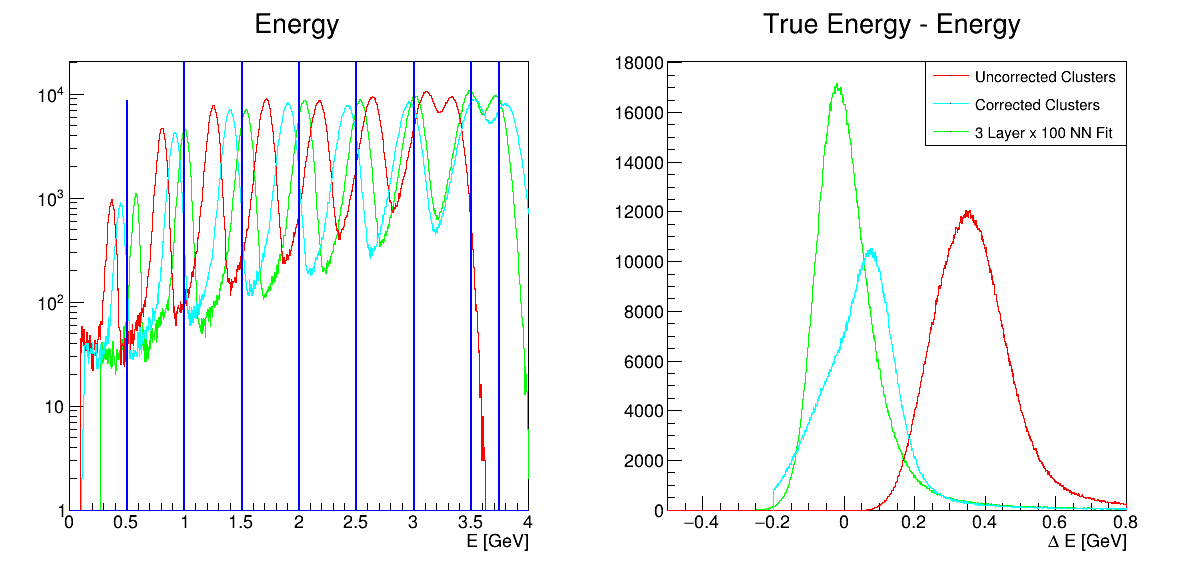

In [58]:
rfile = R.TFile("MLTrainer3_data_val.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_L2_pt01.pdf")

## Again
Reduce the L2 penalty from 0.01 to 0.001 and refit, and keep going down. This below is at 1e-16 for the $\alpha$ parameter, very small.


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_L2_1em16.pdf has been created


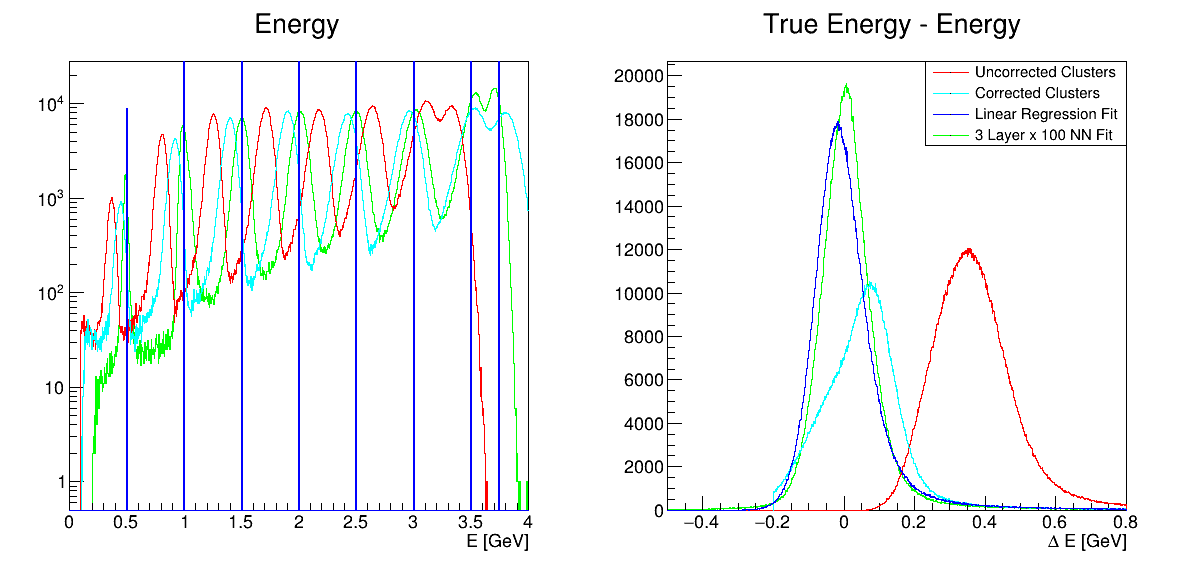

In [66]:
rfile = R.TFile("MLTrainer3_data_val.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
h2_df_fit.SetLineColor(R.kBlue)
h2_df_fit.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_L2_1em16.pdf")

In [71]:
print(f"Lin. Reg fit, mu = {h2_df_fit.GetMean():8.5f} rms={h2_df_fit.GetRMS():8.5f}")
print(f"Deep Learning mu = {h6_df_fit.GetMean():8.5f} rms={h6_df_fit.GetRMS():8.5f}")

Lin. Reg fit, mu =  0.00889 rms= 0.10700
Deep Learning mu =  0.01454 rms= 0.09932


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cc6
Info in <TCanvas::Print>: pdf file Electron_score_e_NN3_L2_1em20.pdf has been created


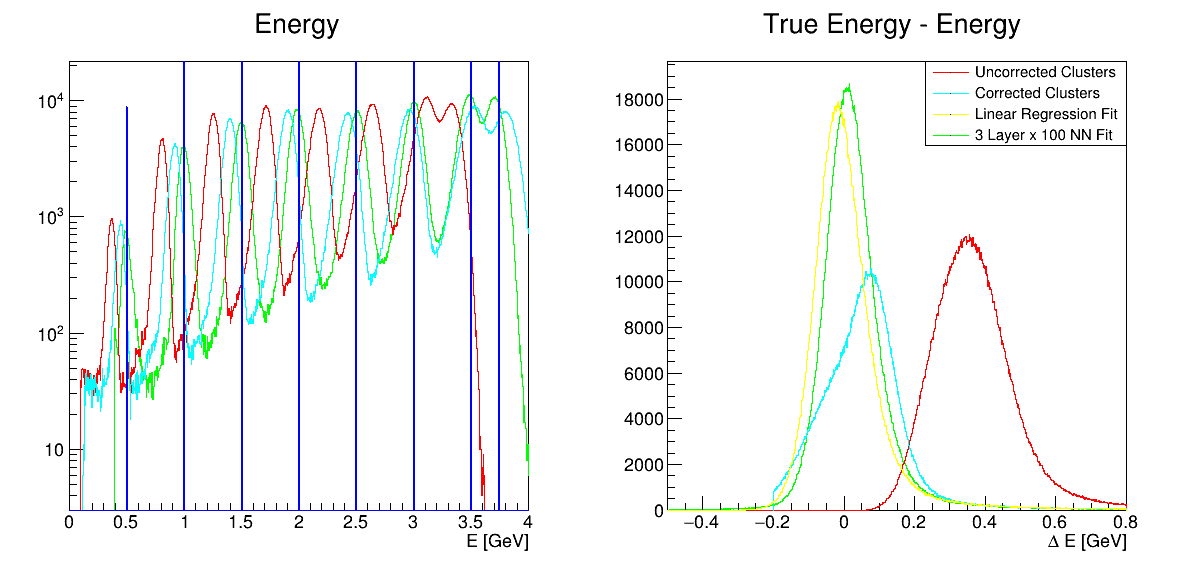

In [21]:
rfile = R.TFile("MLTrainer3_data_val.root")
t = rfile.Get("EcalTraining")
rdf_NN3 = R.RDataFrame(t)
rdf_NN3.GetColumnNames()
h6_true = rdf_NN3.Histo1D(("h_true", "True Energy;E [GeV]", 1000, 0., 4.), "true_e")
h6_clus = rdf_NN3.Histo1D(("h_clus", "Cluster Energy;E [GeV]", 1000, 0., 4.), "energy")
h6_clus_cor = rdf_NN3.Histo1D(("h_clus_cor", "Cluster Energy Cor;E [GeV]", 1000, 0., 4.), "energy_cor")
h6_fit = rdf_NN3.Histo1D(("h_fit", "Fit Energy;E [GeV]", 1000, 0., 4.), "energy_NN")
h6_df_clus = rdf_NN3.Define("d", "true_e - energy").Histo1D(
    ("h_df_clus", "Diff True - Cluster E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
h6_df_clus_cor = rdf_NN3.Define("d", "true_e - energy_cor").Histo1D(
    ("h_df_clus_cor", "Diff True - Corrected Cluster E;#Delta E [GeV]", 1000, -0.2, 0.8), "d")
h6_df_fit = rdf_NN3.Define("d", "true_e - energy_NN").Histo1D(
    ("h_df_fit", "Diff True - Fit E;#Delta E [GeV]", 1000, -0.5, 0.8), "d")
cc6 = R.TCanvas("cc6", "cc6", 1200, 600)
cc6.Divide(2, 1)
p1 = cc6.cd(1)
p1.SetLogy()
h6_clus.SetLineColor(R.kRed)
h6_clus_cor.SetLineColor(R.kCyan)
h6_fit.SetLineColor(R.kGreen)
h6_fit.SetStats(0)
h6_fit.SetTitle("Energy")
h6_fit.Draw()
h6_clus.Draw("same")
h6_clus_cor.Draw("same")
h6_true.SetLineColor(R.kBlue)
h6_true.Draw("same")
p2 = cc6.cd(2)
h6_df_clus.SetLineColor(R.kRed)
h6_df_clus_cor.SetLineColor(R.kCyan)
h6_df_fit.SetLineColor(R.kGreen)
h6_df_fit.SetStats(0)
h6_df_fit.SetTitle("True Energy - Energy")
h6_df_fit.Draw()
h6_df_clus.Draw("same")
h6_df_clus_cor.Draw("same")
h2_df_fit.SetLineColor(R.kYellow)
h2_df_fit.Draw("same")
leg6_p2 = R.TLegend(0.55, 0.75, 0.9, 0.9)
leg6_p2.AddEntry(h6_df_clus.GetPtr(), "Uncorrected Clusters")
leg6_p2.AddEntry(h6_df_clus_cor.GetPtr(), "Corrected Clusters")
leg6_p2.AddEntry(h2_df_fit.GetPtr(),"Linear Regression Fit")
leg6_p2.AddEntry(h6_df_fit.GetPtr(), "3 Layer x 100 NN Fit")
leg6_p2.Draw()
cc6.Draw()
cc6.SaveAs("Electron_score_e_NN3_L2_1em20.pdf")

In [22]:
print(f"Ecal cluster, N = {h6_df_clus_cor.GetEntries()} mu = {h6_df_clus_cor.GetMean():8.5f} rms={h6_df_clus_cor.GetRMS():8.5f}")
print(f"Lin. Reg fit, N = {h2_df_fit.GetEntries()} mu = {h2_df_fit.GetMean():8.5f} rms={h2_df_fit.GetRMS():8.5f}")
print(f"Deep Learning N = {h6_df_fit.GetEntries()} mu = {h6_df_fit.GetMean():8.5f} rms={h6_df_fit.GetRMS():8.5f}")

Ecal cluster, N = 2436666.0 mu =  0.05496 rms= 0.11996
Lin. Reg fit, N = 2436666.0 mu =  0.00901 rms= 0.10711
Deep Learning N = 2436666.0 mu =  0.02843 rms= 0.10158
